In [7]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import HashingVectorizer
#from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer
from matplotlib import pyplot as plt

In [8]:
#Read the data using the Unnamed (probably id) as index
url = 'https://s3.amazonaws.com/drivendata/data/4/public/81e8f2de-9915-4934-b9ae-9705685c9d50.csv'
training = pd.read_csv(url, index_col='Unnamed: 0')

labels = ['Function', 'Object_Type', 'Operating_Status', 'Position_Type', 'Pre_K', 'Reporting', 
          'Sharing', 'Student_Type', 'Use']

numeric = ['FTE', 'Total']

categoric = [ 'Facility_or_Department', 'Function_Description', 
            'Fund_Description', 'Job_Title_Description', 'Location_Description', 
            'Object_Description', 'Position_Extra', 'Program_Description', 'SubFund_Description', 
            'Sub_Object_Description', 
            'Text_1', 'Text_2', 'Text_3', 'Text_4']

In [0]:
training.info()

## Pre-Processing

In [2]:
#Imputing data in Total column
def impute_func_total(data):
    if(pd.isnull(data['Total'])):        
        if(data['Object_Type'] == 'Base Salary/Compensation'):
            return 24146
        if(data['Object_Type'] == 'Benefits'):
            return 38163
        if(data['Object_Type'] == 'Contracted Services'):
            return 24146
        if(data['Object_Type'] == 'Equipment & Equipment Lease'):
            return 11257
        if(data['Object_Type'] == 'NO_LABEL'):
            return 58545
        if(data['Object_Type'] == 'Other Compensation/Stipend'):
            return 1605
        if(data['Object_Type'] == 'Other Non-Compensation'):
            return 10646
        if(data['Object_Type'] == 'Rent/Utilities'):
            return 46611
        if(data['Object_Type'] == 'Substitute Compensation'):
            return 1090
        if(data['Object_Type'] == 'Supplies/Materials'):
            return 7745
        if(data['Object_Type'] == 'Travel & Conferences'):
            return 1659
    else:
        return data['Total']

In [3]:
#Imputing data in FTE column
def impute_func_FTE(data):
    if(pd.isnull(data['FTE'])):        
        if(data['Object_Type'] == 'Base Salary/Compensation'):
            return 0.45
        if(data['Object_Type'] == 'Benefits'):
            return 0.0
        if(data['Object_Type'] == 'Contracted Services'):
            return 0.0
        if(data['Object_Type'] == 'Equipment & Equipment Lease'):
            return 0.0
        if(data['Object_Type'] == 'NO_LABEL'):
            return 0.75
        if(data['Object_Type'] == 'Other Compensation/Stipend'):
            return 0.000107
        if(data['Object_Type'] == 'Other Non-Compensation'):
            return 0.0
        if(data['Object_Type'] == 'Rent/Utilities'):
            return 0.0
        if(data['Object_Type'] == 'Substitute Compensation'):
            return 0.000059
        if(data['Object_Type'] == 'Supplies/Materials'):
            return 0.0
        if(data['Object_Type'] == 'Travel & Conferences'):
            return 0.0
    else:
        return data['FTE']

In [5]:
def preProcessing(training):
    # Remove inconsistent data
    training.loc[training['FTE'] < 0, 'FTE'] = np.nan
    training.loc[training['Total'] < 0, 'Total'] = np.nan
    
    training['Total'] = training.apply(impute_func_total, axis = 1)
    
    #Put FET data greater than 1 in percentage 
    mask = training['FTE'] > 1
    df_ToAtt = training[mask]
    training.loc[mask, 'FTE'] = df_ToAtt['FTE'].div(100)
    
    training['FTE'] = training.apply(impute_func_FTE, axis = 1)
    
    for category in categoric:
        training[category] = training[category].str.lower()
    
    training[categoric] = training[categoric].fillna("")
    
    return training

In [9]:
df_training = preProcessing(training)

In [16]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400277 entries, 134338 to 415831
Data columns (total 25 columns):
Function                  400277 non-null object
Use                       400277 non-null object
Sharing                   400277 non-null object
Reporting                 400277 non-null object
Student_Type              400277 non-null object
Position_Type             400277 non-null object
Object_Type               400277 non-null object
Pre_K                     400277 non-null object
Operating_Status          400277 non-null object
Object_Description        400277 non-null object
Text_2                    400277 non-null object
SubFund_Description       400277 non-null object
Job_Title_Description     400277 non-null object
Text_3                    400277 non-null object
Text_4                    400277 non-null object
Sub_Object_Description    400277 non-null object
Location_Description      400277 non-null object
FTE                       400277 non-null float64
F

## CountVectorizer & HashVectorizer

In [11]:
# Join all text items in a row that have a space in between
text_data = df_training[categoric].apply(lambda x: " ".join(x), axis = 1)

In [12]:
#Stop word list https://aclweb.org/anthology/W18-2502
stop_words = ['a', 'e', 'i', 'o', 'u', 'to', 'all', 'of', 'for', 'and', 'or', 'b', 'with', 'not', 'than', 'other', 'top', 's', 'k', 'in', 'the']

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", ngram_range=(1,2), stop_words = stop_words)

In [114]:
from sklearn.feature_selection import chi2, SelectKBest

X_train_features = vec.fit_transform(text_data)
y_train_labels = df_training["Object_Type"]

ch2 = SelectKBest(chi2, k = 1000)
X_train_x = ch2.fit(X_train_features, y_train_labels)

In [139]:
len(vec.vocabulary_.items())

33552

In [115]:
feature_list = X_train_x.get_support()

In [121]:
feature_list.shape

(33552,)

In [158]:
#list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(33551)]

'zuni sewer'

In [163]:
#List of selected KBest words
features = []
columns = []
for i in range(0, 33552):
    if(feature_list[i]):
        value = list(vec.vocabulary_.keys())[list(vec.vocabulary_.values()).index(i)]
        x = (i, value)
        features.append(x)
        columns.append(i)

In [161]:
features

[(16, '12'),
 (25, '12 high'),
 (36, '12 services'),
 (107, '8 middle'),
 (130, 'aaps'),
 (244, 'account'),
 (369, 'acq'),
 (370, 'acq const'),
 (371, 'acq constr'),
 (376, 'acquisition'),
 (442, 'act part'),
 (491, 'activities'),
 (519, 'activities general'),
 (534, 'activities related'),
 (548, 'activity funds'),
 (590, 'addl'),
 (595, 'addl regular'),
 (914, 'adult'),
 (936, 'adult voc'),
 (937, 'adults'),
 (938, 'adults adult'),
 (1109, 'afterschool'),
 (1112, 'afterschool programs'),
 (1251, 'allotment district'),
 (1280, 'allotment travel'),
 (1286, 'allowances'),
 (1291, 'allowances assessment'),
 (1303, 'allowances nurse'),
 (1305, 'allowances principal'),
 (1309, 'allowances special'),
 (1311, 'allowances teacher'),
 (1313, 'allowances travel'),
 (1872, 'arts sports'),
 (2038, 'assistance'),
 (2045, 'assistance certificated'),
 (2046, 'assistance classroom'),
 (2060, 'assistance general'),
 (2081, 'assistance personal'),
 (2088, 'assistance purchased'),
 (2089, 'assistance reg

In [164]:
#Select only KBest columns
selected_features = X_train_features[:,columns]

In [178]:
df_training[numeric].shape

(400277, 2)

In [186]:
##All the data in space matrix
from scipy import sparse
numeric_features = df_training[numeric].values

training_data = sparse.hstack((selected_features, numeric_features))

In [185]:
training_data.shape

(400277, 1002)

In [187]:
type(training_data)

scipy.sparse.coo.coo_matrix

In [188]:
sparse.save_npz("training_data.npz", training_data)

#read_matrix_back = sparse.load_npz("training_data.npz")

## Simple model to verify tokenization by CountVectorizer and Dimensionality reduction

In [189]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

In [193]:
df_dummies = pd.get_dummies(y_train_labels)

In [194]:
X_train, X_test, y_train, y_test = train_test_split(training_data,
                                                    df_dummies,
                                                    test_size=0.2, 
                                                    random_state=42)

In [196]:
X_train.shape

(320221, 1002)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import FunctionTransformer

from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import TruncatedSVD, NMF

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import GridSearchCV

In [0]:
def combine_text_columns(dataset):
    return dataset[categoric].apply(lambda x: " ".join(x), axis = 1)

In [0]:
get_text_data = FunctionTransformer(combine_text_columns, validate = False)

In [0]:
#text_data = X_train.apply(lambda x: " ".join(x), axis = 1)

In [0]:
#vec = CountVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", ngram_range=(1,2), stop_words = stop_words)
#vec.fit(text_data)
#bag_of_words = vec.transform(text_data)

In [0]:
#matrix = vec.fit_transform(text_data)

In [0]:
#selector = SelectKBest(chi2, k=1000)
#selector.fit(matrix, y_train)
#top_words = selector.get_support().nonzero()

In [0]:
#chi_matrix = matrix[:,top_words[0]]

In [0]:
#sum_words = chi_matrix.sum(axis=0)
#words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
#words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [0]:
stop_words = ['a', 'e', 'i', 'o', 'u', 'to', 'all', 'of', 'for', 'and', 'or', 'b', 'with', 'not', 'than', 'other', 'top', 's', 'k', 'in', 'the']
vec = CountVectorizer(token_pattern="[A-Za-z0-9]+(?=\\s+)", ngram_range=(1,2), stop_words = stop_words)

In [0]:
# Edit model step in pipeline
pl = Pipeline([
        ('selector', get_text_data),
        ('vectorizer', vec),
        #('reduce_dim', TruncatedSVD(n_iter=7, n_components = 1000)),
        #('reduce_dim', NMF(n_components = 200)),
        ('reduce_dim', SelectKBest(chi2, 1000)),
        ('clf', RandomForestClassifier())
    ])

In [26]:
# Fit to the training data
pl.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
     steps=[('selector', FunctionTransformer(accept_sparse=False, check_inverse=True,
          func=<function combine_text_columns at 0x7f827828b048>,
          inv_kw_args=None, inverse_func=None, kw_args=None,
          pass_y='deprecated', validate=False)), ('vectorizer', CountVectorizer(analyzer='wo...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [27]:
from sklearn.metrics import accuracy_score

y_pred = pl.predict(X_test)
accuracy_score(y_test.values, y_pred, normalize=True)

0.9786274607774558

In [0]:
N_FEATURES_OPTIONS = [200, 500, 1000]
#mean_scores_10000 = [[0.904, 0.92175, 0.82725], [0.892, 0.9205, 0.91425]]
#mean_score_all_dataSet = [[0.9661736784251024, 0.9259018686919157], [0.963250724492855, 0.9740181872689118], [0.9565054461876686, 0.9786274607774558]]
mean_score_all_dataSet = [0.9661736784251024, 0.963250724492855, 0.9565054461876686, 0.9259018686919157, 0.9740181872689118, 0.9786274607774558]

In [0]:
reducer_labels = ['SVD', 'KBest(chi2)']

In [0]:
N_FEATURES_OPTIONS = [100, 200, 1000]
C_OPTIONS = [100, 200, 300, 1000]
param_grid = [
    {
        'reduce_dim': [TruncatedSVD(n_iter=7), NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'clf__n_estimators': C_OPTIONS
    },
    {
        'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k': N_FEATURES_OPTIONS,
        'clf__n_estimators': C_OPTIONS
    },
]
reducer_labels = ['SVD', 'NMF', 'KBest(chi2)']

In [0]:
grid = GridSearchCV(pl, cv=5, n_jobs=1, param_grid=param_grid)

#grid.fit(X_train, y_train)

In [0]:
#mean_scores = np.array(grid.cv_results_['mean_test_score'])
mean_scores = np.array(mean_score_all_dataSet)
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(1, -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)


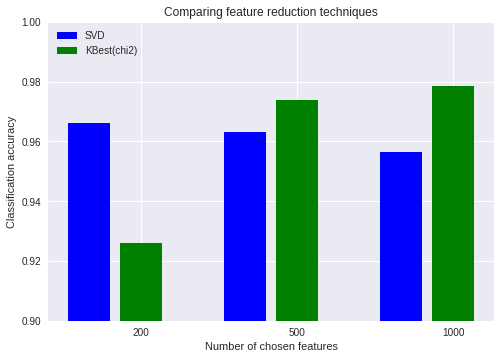

In [44]:
plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Number of chosen features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Classification accuracy')
plt.ylim((0.90, 1))
plt.legend(loc='upper left')

plt.show()
#SVD = [0.9661736784251024, 0.963250724492855, 0.9565054461876686]
#mean_score_all_dataSet = [0.9661736784251024, 0.963250724492855, 0.9565054461876686, 0.9259018686919157, 0.9740181872689118, 0.9786274607774558]

In [0]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 320221 entries, 444691 to 172004
Data columns (total 14 columns):
Facility_or_Department    320221 non-null object
Function_Description      320221 non-null object
Fund_Description          320221 non-null object
Job_Title_Description     320221 non-null object
Location_Description      320221 non-null object
Object_Description        320221 non-null object
Position_Extra            320221 non-null object
Program_Description       320221 non-null object
SubFund_Description       320221 non-null object
Sub_Object_Description    320221 non-null object
Text_1                    320221 non-null object
Text_2                    320221 non-null object
Text_3                    320221 non-null object
Text_4                    320221 non-null object
dtypes: object(14)
memory usage: 36.6+ MB


## Save df in a new CSV

In [0]:
training.to_csv(index = False)